## Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import libraries

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Drugs.com Data

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/drug review SA'

In [ ]:
train_data = pd.read_csv(PATH + '/data/Drugs/drugsComTrain_raw.csv')
test_data = pd.read_csv(PATH +'/data/Drugs/drugsComTest_raw.csv')
df = pd.concat([train_data, test_data])
df.shape

(215063, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 13.1+ MB


In [ ]:
drop_cols = ['uniqueID', 'drugName', 'condition', 'date', 'usefulCount']
df = df.drop(drop_cols, axis =1)
df.head()

,review,rating
0,"""It has no side effect, I take it in combinati...",9
1,"""My son is halfway through his fourth week of ...",8
2,"""I used to take another oral contraceptive, wh...",5
3,"""This is my first time using any form of birth...",8
4,"""Suboxone has completely turned my life around...",9


### count of reviews for each number of ratings

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


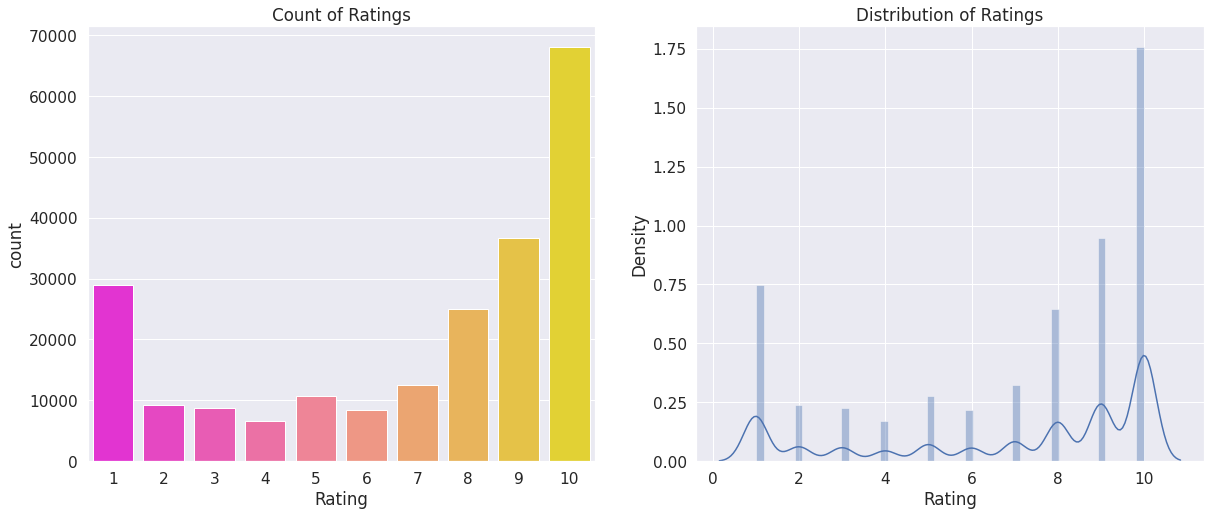

In [ ]:
# A countplot of the ratings so we can see the distribution of the ratings
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'darkgrid')
fig, ax = plt.subplots(1, 2)

sns_1 = sns.countplot(df['rating'], palette = 'spring',  ax = ax[0])
sns_2 = sns.distplot(df['rating'], ax = ax[1])
sns_1.set_title('Count of Ratings')
sns_1.set_xlabel("Rating")

sns_2.set_title('Distribution of Ratings')
sns_2.set_xlabel("Rating");

### labeling the reviews into positive, neutral and negative

In [ ]:
df.loc[(df['rating'] <= 4), 'Review_Sentiment'] = 'negative'   # neagtive review
df.loc[(df['rating'] > 4) &                       
       (df['rating'] < 7), 'Review_Sentiment'] = 'neutral'     # neutral review
df.loc[(df['rating'] >= 7), 'Review_Sentiment'] = 'positive'    # positve review

df['Review_Sentiment'].value_counts()

positve     105433
negative    100071
neutral       9559
Name: class, dtype: int64

### Word cloud for each class labels

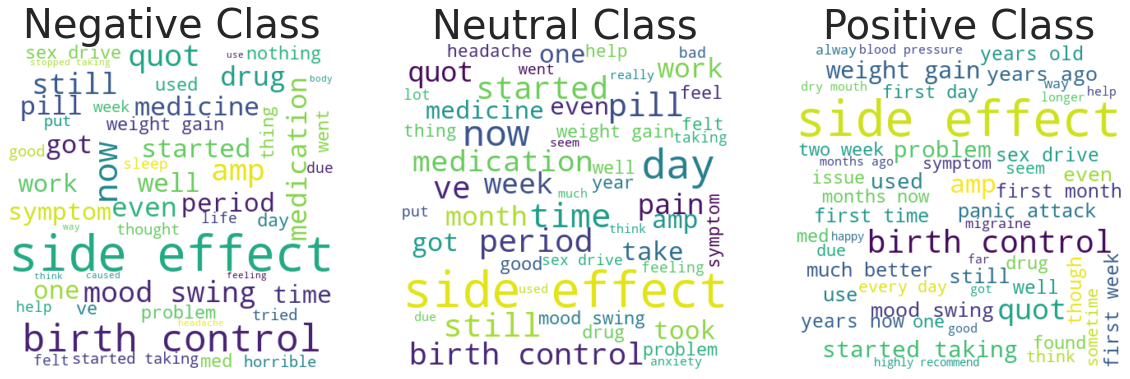

In [ ]:
#wordcloud to see importance of word for each label
from wordcloud import WordCloud

df.review=df.review.apply(str)

# Start with one review:
df_Negative = df[df['Review_Sentiment']=='negative']
df_Positive = df[df['Review_Sentiment']=='positive']
df_Neutral = df[df['Review_Sentiment']=='neutral']

text_Neg = " ".join(review for review in df_Negative.review)
text_Pos = " ".join(review for review in df_Positive.review)
text_Neu = " ".join(review for review in df_Neutral.review)

fig, (ax1, ax2, ax3) = plt.subplots( 1, 3 , figsize  = (20,20))
# Create and generate a word cloud image:
wordcloud_Neg = WordCloud(height=400,max_words=50,background_color="white",collocations=True,max_font_size=100).generate(text_Neg)
wordcloud_Pos = WordCloud(height=400,max_words=50,background_color="white",collocations=True,max_font_size=100).generate(text_Pos)
wordcloud_Neu = WordCloud(height=400,max_words=50,background_color="white",collocations=True,max_font_size=100).generate(text_Neu)


# Display the generated image:
ax1.imshow(wordcloud_Neg, interpolation='bilinear')
ax1.set_title('Negative Class',fontsize=40)
ax1.axis('off')

ax2.imshow(wordcloud_Neu, interpolation='bilinear')
ax2.set_title('Neutral Class',fontsize=40)
ax2.axis('off')

ax3.imshow(wordcloud_Pos, interpolation='bilinear')
ax3.set_title('Positive Class',fontsize=40)
ax3.axis('off');



### Text preprocessing

**Expanding the contractions**

In [ ]:
### start of cleaning comment ###

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because",
                       "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not",
                       "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", 
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  
                       "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                       "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                       "mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not",
                       "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                       "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", 
                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", 
                       "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                       "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is",
                       "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                       "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would",
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", 
                       "you've": "you have" }


In [ ]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

# lower each words in a review
df['cleaned_reviews'] = df['review'].apply(lambda x: x.lower()) 

# expand contractions
df['cleaned_reviews'] = df['cleaned_reviews'].apply(lambda x: clean_contractions(x, contraction_mapping))

**Remove punctuations and special characters**

In [ ]:
spec_chars = ["!",'"',"।","#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df['cleaned_reviews'] = df['cleaned_reviews'].str.replace(char, ' ') 
    df['cleaned_reviews'] = df['cleaned_reviews'].str.split().str.join(' ')         #remove whitespace

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [ ]:
df.head()

,review,rating,Review_Sentiment,cleaned_reviews
0,"""It has no side effect, I take it in combinati...",9,positive,it has no side effect i take it in combination...
1,"""My son is halfway through his fourth week of ...",8,positive,my son is halfway through his fourth week of i...
2,"""I used to take another oral contraceptive, wh...",5,neutral,i used to take another oral contraceptive whic...
3,"""This is my first time using any form of birth...",8,positive,this is my first time using any form of birth ...
4,"""Suboxone has completely turned my life around...",9,positive,suboxone has completely turned my life around ...


**Remove Stop words**

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

df["cleaned_reviews"] = df["cleaned_reviews"].apply(lambda words: ' '.join(word for word in words.split() if word not in stoplist))

**Remove digits**

In [ ]:
df['cleaned_reviews'] = df['cleaned_reviews'].str.replace('\d+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
df.head()

,review,rating,Review_Sentiment,cleaned_reviews
0,"""It has no side effect, I take it in combinati...",9,positive,side effect take combination bystolic mg fish...
1,"""My son is halfway through his fourth week of ...",8,positive,son halfway fourth week intuniv became concern...
2,"""I used to take another oral contraceptive, wh...",5,neutral,used take another oral contraceptive pill cyc...
3,"""This is my first time using any form of birth...",8,positive,first time using form birth control glad went...
4,"""Suboxone has completely turned my life around...",9,positive,suboxone completely turned life around feel he...


**Lemmatization**

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["cleaned_reviews"] = df["cleaned_reviews"].apply(lambda text: lemmatize_words(text))

**Spell correction**

In [ ]:
from textblob import TextBlob
df['cleaned_reviews'] = df.cleaned_reviews.apply(lambda txt: ''.join(TextBlob(txt).correct()))


In [ ]:
df.head()

,review,rating,Review_Sentiment,cleaned_reviews
0,"""It has no side effect, I take it in combinati...",9,positive,side effect take combination bystolic mg fish oil
1,"""My son is halfway through his fourth week of ...",8,positive,son halfway fourth week intuniv become concern...
2,"""I used to take another oral contraceptive, wh...",5,neutral,use take another oral contraceptive pill cycle...
3,"""This is my first time using any form of birth...",8,positive,first time use form birth control glad go patc...
4,"""Suboxone has completely turned my life around...",9,positive,suboxone completely turn life around feel heal...


In [ ]:
df.to_csv(PATH + '/data/results/clean_df.csv', index = False)